# Sparse Filtering (SFt) of ABA Spatial Transcriptomics

In [ ]:
# In this project, the publicly available python script by Dr. Metzen was used
# Available on this GitHub: https://github.com/jmetzen/sparse-filtering
# First, installing it

!pip install sparse_filtering

In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sparse_filtering import SparseFiltering

In [ ]:
# Loading the preprocessed data into the pipeline
# The steps are explained in the '00_preprocessing' folder
# Summary: E(v,g) matrix is made, masked for brain, -1s changed to 0s, and standard scaled
# NOT INCLUDED in the files folder of this repo

X = np.load('preprocessed_data/mask_pos_std.npy')

In [ ]:
# Running Sparse Filtering

estimator = SparseFiltering(n_features = n_features)
features = estimator.fit_transform(X)
weights = estimator.w_

In [ ]:
# Clustering the features

kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit_predict(features)
labels = kmeans.labels_

**Visualization of Features**

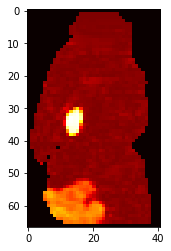

In [13]:
# Here, we visualize a selected feature out of n_features
# Since the brain was masked before running Sparse Filtering,
# It has to be rebuilt to brain shape before visualization
# for that we use the reconstruct_ABA function

# Selecting the feature
feature_number = 0 # Selecting the feature to visualize
selected_feature = features[:, feature_number]

# Reconstructing the feature
indices_path = 'files/mask_indices.npy'
reconstructed_arr = reconstruct_ABA(selected_feature, indices_path, mirror = False,\
                            outside_value = np.nan, array_3D = True)

# Selecting a slice
vol = reconstructed_arr.reshape(67,58,41)  # If array_3D = True, the output is already 3D
s = vol[:, slice_number,:]  # Choosing the first, second, or third dimension would change the view
plt.imshow(s, cmap = 'hot') # Colormap could be chosen from matplotlib's available cmaps

**Visualization of Clusters**

In [ ]:
# Here, we visualize the clusters in a selected slice and view
# Since the brain was masked before running Sparse Filtering,
# It has to be rebuilt to brain shape before visualization
# for that we use the reconstruct_ABA function

# Reconstructing the labels
indices_path = 'files/mask_indices.npy'
reconstructed_arr = reconstruct_ABA(labels_rc, indices_path, mirror = False,\
                            outside_value = np.nan, array_3D = True)

# Selecting a slice
vol = reconstructed_arr.reshape(67,58,41)  # If array_3D = True, the output is already 3D
s = vol[:, slice_number,:]  # Choosing the first, second, or third dimension would change the view
plt.imshow(s, cmap = 'hot') # Colormap could be chosen from matplotlib's available cmaps

**Similarity Measures**

In [ ]:
# Checking the AMI score of the clusters and the Neuroanatomy
# The Neuroanatomy is the Allen Mouse Brain average

# Loading the Allen Reference Atlas
reference = np.load('files/allen_annot200_mask.npy')

print(AMI(labels, reference))

**Clustering One Feature**
<br>To see where the feature is active in

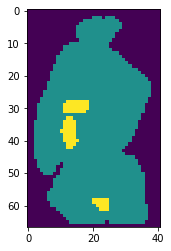

In [59]:
# Selecting the feature
feature = features[:, feature_number].reshape(-1,1)

# Running clustering
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
kmeans.fit_predict(feature)
labels = kmeans.labels_

# Reconstructing the labels
indices_path = '/data/bioprotean/ABA/MEMMAP/genes_list/half_indices.npy'
labels_rc = reconstruct_ABA(labels, indices_path, mirror = False,\
                            outside_value = np.nan, array_3D = True)

# Visualizing the slice
slice_n = 20
slice = labels_rc[:,slice_n,:]
plt.imshow(slice)

**Clustering Single Features Separately**

In [37]:
'''Saving separate clusters to a single array'''

# Making an array to store all labels
labels_arr = np.zeros((features.shape[0], total_features))

for feature_n in range(total_features):
    # Selecting the feature
    feature = features[:, feature_n].reshape(-1,1)
    
    # Running clustering
    n_clusters = 2
    kmeans = KMeans(n_clusters = n_clusters, random_state = 0)
    kmeans.fit_predict(feature)
    labels = kmeans.labels_
    labels_arr[:, feature_n] = labels

np.save('/data/bioprotean/ABA/DLSC/mask/alphas/a0.1_'+str(total_features)+'dict_total_labels.npy', labels_arr)

In [ ]:
'''Computing MICE score for brain regions'''

# Loading all the labels
total_features = 100
labels_arr = np.load('/data/bioprotean/ABA/SFT/mask/100features_total_labels.npy')

# Making a desired dataframe
df_path = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/RAG2_neg_comp_overlap_anat.csv'
overlap_df = pd.read_csv(df_path, index_col = 'Unnamed: 0')

# overlap_df.drop(columns = 'region_overlap_ration', 'jac_overlap_ratio', 'DICE_neg_jcb_anat')
for i in range(total_features):
    overlap_df['MICE_feature_'+str(i)] = np.nan

# Inputting the indices path
indices_path = '/data/bioprotean/ABA/MEMMAP/genes_list/mask_indices.npy'

# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)

# Loading the region IDs list
region_ids_list = overlap_df['ant_id']

for row, ID in enumerate(region_ids_list):  
    
    # Masking the brain by the region ID
    masked_brain = np.where(ant_vec == ID, 1, 0)
    count_region = np.sum(masked_brain)
    
    # Making a list to store
    overlap_list_region = []
    
    # Looping over clusters
    for i in range(total_features):
        
        # Selecting the label
        labels = labels_arr[:, i]
        
        # Selecting the smaller cluster between two
        counts = np.unique(labels, return_counts = True)[1]
        cluster_ID = np.argmin(counts)
        cluster_ids = [cluster_ID]
        
        # Reconstructing the labels
        labels_rc = reconstruct_ABA(labels, indices_path)
        
        # Masking the clusters
        masked_cluster = np.where(labels_rc == cluster_ID, 1, 0)
        
        # Counting the overlap and adding to the DataFrame
        count_overlap = np.vdot(masked_brain, masked_cluster)
        overlap_ratio = count_overlap / count_region
        overlap_df['MICE_feature_'+str(i)].loc[row] = overlap_ratio

# Saving to file
overlap_df.to_csv('/data/bioprotean/ABA/SFT/mask/100MICE_region_separate_clusters.csv')

In [3]:
'''Computing DICE score for brain regions'''

# Cluster selection
cluster_selection = 'intensity' # {'intensity', 'count', 'best_overlap'}

# Loading the labels
labels_arr = np.load('/data/bioprotean/ABA/SFT/mask/100features_total_labels.npy')
total_features = labels_arr.shape[1]

# Loading the features
features_path = '/data/bioprotean/ABA/SFT/mask/features/100_features.npy'
features = np.load(features_path)

# Making a desired dataframe
df_path = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/RAG2_neg_comp_overlap_anat.csv'
overlap_df = pd.read_csv(df_path, index_col = 'Unnamed: 0')
region_ids_list = overlap_df['ant_id']
for i in range(total_features):
    overlap_df['DICE_feature_'+str(i)] = np.nan

# Inputting the indices path
indices_path = '/data/bioprotean/ABA/MEMMAP/genes_list/mask_indices.npy'

# Loading the anatomy file
ant_file = '/data/bioprotean/RAG2/AVG/MWT_avg/to_allen/overlap/200um/allen_annot200.nii'
ant_vec = nifti_to_array(ant_file)
    
for row, ID in enumerate(region_ids_list):
    
    # Masking the brain by the region ID
    masked_brain = np.where(ant_vec == ID, 1, 0)
    count_region = np.sum(masked_brain)
    
    # Looping over clusters
    for i in range(total_features):
        
        # Selecting the label and feature
        labels = labels_arr[:, i]
        feature = features[:, i]
        
        
        # Selecting the cluster ID
        if cluster_selection == 'intensity':
            
            # Making a list of average intensities in the clustered feature
            avg_feature_intensity_list = []

            for label_val in range(2):
                masked_feature = np.where(labels == label_val, feature, 0)
                count_nonzero = np.count_nonzero(masked_feature)
                average_feature = np.sum(masked_feature) / count_nonzero
                avg_feature_intensity_list.append(average_feature)

            cluster_ID = avg_feature_intensity_list.index(max(avg_feature_intensity_list))
            
            
        elif cluster_selection == 'count':
            
            # Selecting the smaller cluster between two
            counts = np.unique(labels, return_counts = True)[1]
            cluster_ID = np.argmin(counts)
        
        
        elif cluster_selection == 'best_overlap':
            
            # Making a list of overlaps for both clusters
            clusters_overlap_list = []
            
            for cluster_ID in range(2):
                
                # Reconstructing the labels
                labels_rc = reconstruct_ABA(labels, indices_path, mirror = False)

                # Masking the clusters
                masked_cluster = np.where(labels_rc == cluster_ID, 1, 0)
                count_cluster = np.sum(masked_cluster)

                # Counting the overlap and adding to the list
                count_overlap = np.vdot(masked_brain, masked_cluster)
                overlap_ratio = (2 * count_overlap) / (count_region + count_cluster)
                clusters_overlap_list.append(overlap_ratio)
            
            # Adding maximum overlap ratio to the dataframe
            overlap_df['DICE_feature_'+str(i)].loc[row] = max(clusters_overlap_list)
            
            
        if cluster_selection in ['count', 'intensity']:
            # Reconstructing the labels
            labels_rc = reconstruct_ABA(labels, indices_path, mirror = False)

            # Masking the clusters
            masked_cluster = np.where(labels_rc == cluster_ID, 1, 0)
            count_cluster = np.sum(masked_cluster)

            # Counting the overlap and adding to the DataFrame
            count_overlap = np.vdot(masked_brain, masked_cluster)
            overlap_ratio = (2 * count_overlap) / (count_region + count_cluster)
            overlap_df['DICE_feature_'+str(i)].loc[row] = overlap_ratio

# Saving to file
overlap_df.to_csv('/data/bioprotean/ABA/SFT/mask/100DICE_region_separate_clusters_'+cluster_selection+'.csv')

/home/mabbasi6/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [3]:
# Finding top regions with top DICE scores
overlap_df = pd.read_csv('/data/bioprotean/ABA/SFT/mask/100DICE_region_separate_clusters.csv', index_col = 'Unnamed: 0')
overlap_df.head()

,full_ant_index,structure,acronym,ish_id,ant_id,in_200_atlas,region_overlap_ratio,jac_overlap_ratio,DICE_neg_jcb_anat,DICE_feature_0,...,DICE_feature_90,DICE_feature_91,DICE_feature_92,DICE_feature_93,DICE_feature_94,DICE_feature_95,DICE_feature_96,DICE_feature_97,DICE_feature_98,DICE_feature_99
0,0,"""root""","""root""",-1.0,997,True,0.069196,0.010389,0.018065,0.018274,...,0.0,0.000000,0.001919,0.024797,0.007937,0.010309,0.0,0.000000,0.041805,0.014365
1,7,"""Frontal pole, layer 1""","""FRP1""",998.0,68,True,0.300000,0.002011,0.003995,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.010375,0.000000,0.000000
2,8,"""Frontal pole, layer 2/3""","""FRP2/3""",1073.0,667,True,0.250000,0.002346,0.004648,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.010351,0.000000,0.000000
3,19,"""Primary motor area, Layer 1""","""MOp1""",888.0,320,True,0.000000,0.000000,0.000000,0.000000,...,0.0,0.048269,0.026819,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,20,"""Primary motor area, Layer 2/3""","""MOp2/3""",966.0,943,True,0.000000,0.000000,0.000000,0.000000,...,0.0,0.098375,0.060891,0.000000,0.000000,0.000000,0.0,0.066191,0.023653,0.000000


In [4]:
'''Choosing the top regions and DICE scores'''

# Cluster selection
cluster_selection = 'best_overlap' # {'intensity', 'count', 'best_overlap'}

# Loading the overlap dataframe
overlap_path = '/data/bioprotean/ABA/SFT/mask/100DICE_region_separate_clusters_'+cluster_selection+'.csv'
overlap_df = pd.read_csv(overlap_path, index_col = 'Unnamed: 0')

# Selecting the part of dataframe for DICE values
dropped_columns = ['full_ant_index','ish_id','ant_id','region_overlap_ratio','jac_overlap_ratio','DICE_neg_jcb_anat']
DICE_df = overlap_df.drop(labels = dropped_columns, axis = 1)

# List of regions and DICE scores
region_list = []
DICE_list = []

for feature_n in range(100):
    
    # Sorting by the weights in each column
    sorted_df = DICE_df.sort_values(by=['DICE_feature_'+str(feature_n)], ascending=False, na_position='last')
    sorted_df.reset_index(drop=True, inplace=True)
    
    # Selecting the region
    region_name = sorted_df['acronym'].loc[:0].tolist()
    region_list.extend(region_name)
    
    # Selecting the DICE score
    DICE_value = sorted_df['DICE_feature_'+str(feature_n)].loc[:0].tolist()
    DICE_list.extend(DICE_value)

# Top DICE dataframe
top_df = pd.DataFrame()
top_df['acronym'] = region_list
top_df['DICE_score'] = DICE_list
top_df['feature_ID'] = range(100)

# Sorting by the weights in each column
top_sorted_df = top_df.sort_values(by=['DICE_score'], ascending=False, na_position='last')
top_sorted_df.reset_index(drop=True, inplace=True)
top_sorted_df.head()

# top_sorted_df[top_sorted_df['acronym'] == '"CA1"'].shape[0]
# top_sorted_df['acronym'].value_counts()

,acronym,DICE_score,feature_ID
0,"""CA1""",0.731826,94
1,"""PIR""",0.661534,90
2,"""CA1""",0.658389,13
3,"""CP""",0.621465,49
4,"""CP""",0.600654,99


# Finding top genes for brain regions

In [ ]:
'''Finding the top genes for each brain region'''

# Inputting the ID of the brain region
brain_region_ID = 10703
n_top_genes = 5
output_type = 'Gene' # or 'Entrez ID'

# Loading overlap dataframe of separate features and brain regions
overlap_df_path = '/data/bioprotean/ABA/SFT/mask/100MICE_region_separate_clusters.csv'
overlap_df = pd.read_csv(overlap_df_path, index_col = 'Unnamed: 0')

# Extracting the top feature for the brain region
feature_str = overlap_df[overlap_df['ant_id'] == brain_region_ID].iloc[:,9:].idxmax(axis = 1).tolist()[0]
feature_name = feature_str.replace('MICE_', '')

# Loading weights dataframe of genes and features
genes_df = pd.read_csv('/data/bioprotean/ABA/SFT/mask/100_weights_df.csv', index_col = 'Unnamed: 0')

# Sorting the daraframe by the desired feature number
sorted_df = genes_df.sort_values(by=[feature_name], ascending=False, na_position='last')
sorted_df.reset_index(drop=True, inplace=True)

# Selecting the output
output_list = sorted_df[output_type].loc[:n_top_genes].tolist()
output_list

In [10]:
overlap_df.head()

,full_ant_index,structure,acronym,ish_id,ant_id,in_200_atlas,region_overlap_ratio,jac_overlap_ratio,DICE_neg_jcb_anat,MICE_feature_0,...,MICE_feature_90,MICE_feature_91,MICE_feature_92,MICE_feature_93,MICE_feature_94,MICE_feature_95,MICE_feature_96,MICE_feature_97,MICE_feature_98,MICE_feature_99
0,0,"""root""","""root""",-1.0,997,True,0.069196,0.010389,0.018065,0.185268,...,0.0,0.000000,0.024554,0.122768,0.017857,0.055804,0.0,0.000000,0.140625,0.087054
1,7,"""Frontal pole, layer 1""","""FRP1""",998.0,68,True,0.300000,0.002011,0.003995,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.900000,0.000000,0.000000
2,8,"""Frontal pole, layer 2/3""","""FRP2/3""",1073.0,667,True,0.250000,0.002346,0.004648,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.642857,0.000000,0.000000
3,19,"""Primary motor area, Layer 1""","""MOp1""",888.0,320,True,0.000000,0.000000,0.000000,0.000000,...,0.0,0.273810,0.892857,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,20,"""Primary motor area, Layer 2/3""","""MOp2/3""",966.0,943,True,0.000000,0.000000,0.000000,0.000000,...,0.0,0.228033,0.732218,0.000000,0.000000,0.000000,0.0,0.271967,0.075314,0.000000


# Finding gene weights for each feature

In [ ]:
'''Making a DataFrame of gene weights and genes information'''

# Selecting the number of features
n_features = 100

# Loading the weights array
weights = np.load('/data/bioprotean/ABA/SFT/mask/features/'+str(n_features)+'_weights.npy')

# Loading the genes dataframe
genes_df = pd.read_csv('/data/bioprotean/ABA/MEMMAP/genes_list/final_list.csv') 

# Inputting the weights to this dataframe:
for i in range(n_features):
    genes_df['feature_' + str(i)] = weights[i, :]

# Saving the dataframe to file
genes_df.to_csv('/data/bioprotean/ABA/SFT/mask/'+str(n_features)+'_weights_df.csv')

In [19]:
# Loading gene weights dataframe
genes_df = pd.read_csv('/data/bioprotean/ABA/SFT/mask/100_weights_df.csv', index_col = 'Unnamed: 0')
genes_df.head()

,Old Index,Gene,Entrez ID,Image Series URL,Used in analysis?,ID,feature_0,feature_1,feature_2,feature_3,...,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99
0,0,0610007P14Rik,58520,0610007P14Rik/70927828.html,1,70927828,-166588.772006,-86917.724997,906530.952865,-332986.879362,...,227745.290794,8419.358974,-732226.899765,-248228.355274,287162.640259,-6.464677e+05,230617.281391,-288716.744084,-22075.533517,-7.728983e+03
1,1,0610010D24Rik,68339,0610010D24Rik/74363346.html,1,74363346,-667077.783424,-748562.073641,-887212.974131,577540.033300,...,-451627.613233,486681.924883,138815.178337,108423.847696,884323.060954,6.115380e+05,-395796.302361,-105877.864907,-717305.954328,-1.807557e+06
2,2,0610010O12Rik,66060,0610010O12Rik/75079788.html,1,75079788,-242865.758414,333574.271578,68638.765792,-619375.282766,...,-425992.767875,529832.724122,-439710.924560,-553070.785294,-307620.282405,-5.053870e+05,-45887.842993,43356.781415,626970.771082,-3.512379e+05
3,3,0610011I04Rik,66058,0610011I04Rik/75650863.html,1,75650863,193499.662273,-85232.309595,-244644.427825,-415407.865313,...,-403972.332739,-114284.933349,33473.495492,-30052.613133,48795.542955,-1.024471e+06,474720.102687,-184816.939828,-988243.601868,1.515064e+05
4,5,0610042C05Rik,66084,0610042C05Rik/77371805.html,1,77371805,-153158.310606,629799.844362,-214309.776968,380061.677679,...,168722.414906,-481734.975094,-803851.234218,145393.779419,-251658.020126,2.635023e+05,622230.999264,-116660.818384,-100287.339573,-7.132325e+04


**Getting top 10 gene IDs for each feature**

In [20]:
# Making a dataframe for the features and genes
top10_df = pd.DataFrame(\
        columns = [f'gene_{i}' for i in range(10)],\
        index = [f'feature_{i}' for i in range(100)])

In [21]:
# Getting 10 genes for each feature
for i in range(100):
    
    # Sorting the weights dataframe by weights for each feature
    sorted_df = genes_df.sort_values(by=[f'feature_{i}'], ascending=False, na_position='last')
    sorted_df.reset_index(drop=True, inplace=True)
    
    # Selecting the gene IDs from it
    genes_10 = sorted_df['Gene'].iloc[:10].tolist()
    
    # Assigning these IDs to the rows of top 10 dataframe
    top10_df.loc[f'feature_{i}'] = genes_10

In [22]:
top10_df.to_csv('/data/bioprotean/ABA/SFT/mask/top10_gene_IDs_per_feature.csv')

# Finding top genes for each feature

In [2]:
def impacting_genes_finder(brain_region_ID, n_top_genes = 5, output_type = 'Gene', ascending = False):
    '''
    Takes the brain region ID and outputs the top desired gene names/Entrez IDs.
    Could go either in ascending/descending mode.
    
    Arguments:
        brain_region_ID: int
            Annotation ID of the brain region.
        
        n_top_genes: int, default = 5
            Number of top genes looking to extract.
        
        output_type: {'Gene', 'Entrez ID'}, default = 'Gene'
            The type of output looking to retrieve.
        
        ascending: bool, default = False
            Sorting genes in descending/ascending mode.
    
    Parameters:
        output_list: list
            List of desired output genes.
    '''
    
    # Loading overlap dataframe of separate features and brain regions
    overlap_df_path = '/data/bioprotean/ABA/SFT/mask/100MICE_region_separate_clusters.csv'
    overlap_df = pd.read_csv(overlap_df_path, index_col = 'Unnamed: 0')

    # Extracting the top feature for the brain region
    feature_str = overlap_df[overlap_df['ant_id'] == brain_region_ID].iloc[:,9:].idxmax(axis = 1).tolist()[0]
    feature_name = feature_str.replace('MICE_', '')
    print('Feature name is: ', feature_name)

    # Loading weights dataframe of genes and features
    genes_df = pd.read_csv('/data/bioprotean/ABA/SFT/mask/100_weights_df.csv', index_col = 'Unnamed: 0')

    # Sorting the daraframe by the desired feature number
    sorted_df = genes_df.sort_values(by=[feature_name], ascending=ascending, na_position='last')
    sorted_df.reset_index(drop=True, inplace=True)

    # Selecting the output
    output_list = sorted_df[output_type].loc[:n_top_genes-1].tolist()
    
    return output_list

In [ ]:
# Inputting the ID of the brain region
brain_region_ID = 382
n_top_genes = 30
output_type = 'Gene' # or 'Entrez ID'
ascending = False

impacting_genes_finder(brain_region_ID, n_top_genes=n_top_genes, output_type=output_type, ascending=ascending)

# DICE scores of brain regions

In [3]:
# Loading dataframe
DICE_df = pd.read_csv('/data/bioprotean/ABA/SFT/mask/100f_200c_max_DICE.csv', index_col='Unnamed: 0')

# Sorting by DICE score
sorted_df = DICE_df.sort_values(by=['max_DICE'], ascending=False, na_position='last')
sorted_df.reset_index(drop=True, inplace=True)
sorted_df.head(20)

,full_ant_index,structure,acronym,ish_id,ant_id,in_200_atlas,region_overlap_ratio,jac_overlap_ratio,DICE_neg_jcb_anat,max_DICE
0,457,"""Field CA1""","""CA1""",47.0,382,True,0.002315,0.001005,0.001402,0.621389
1,573,"""Caudoputamen""","""CP""",83.0,672,True,0.088754,0.097855,0.093083,0.553599
2,336,"""Retrosplenial area, ventral part, layer 5""","""RSPv5""",651.0,687,True,0.000000,0.000000,0.000000,0.534328
3,105,"""Supplemental somatosensory area, layer 6a""","""SSs6a""",956.0,862,True,0.000000,0.000000,0.000000,0.530283
4,912,"""Pontine gray""","""PG""",823.0,931,True,0.000000,0.000000,0.000000,0.518703
5,942,"""Ventral cochlear nucleus""","""VCO""",861.0,101,True,0.030303,0.001340,0.002567,0.510511
6,187,"""Primary visual area, layer 2/3""","""VISp2/3""",951.0,821,True,0.000000,0.000000,0.000000,0.506876
7,712,"""Medial habenula""","""MH""",201.0,483,True,0.097561,0.001340,0.002645,0.503067
8,104,"""Supplemental somatosensory area, layer 5""","""SSs5""",1126.0,1090,True,0.000000,0.000000,0.000000,0.501119
9,416,"""Piriform area""","""PIR""",261.0,961,True,0.012431,0.006032,0.008123,0.493621
